# Scoring pour le risque crédit

In [1]:
# Chargement des bibliothèques et des modules
import os
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from datetime import datetime
from collections import Counter
from numpy import where

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

### Importation des tables

In [3]:
train = pd.read_csv("data/application_train.csv")
test = pd.read_csv("data/application_test.csv")
bureau = pd.read_csv("data/bureau.csv")
bureau_balance = pd.read_csv("data/bureau_balance.csv")
cc = pd.read_csv('data/credit_card_balance.csv')
ins = pd.read_csv('data/installments_payments.csv')
pos = pd.read_csv('data/POS_CASH_balance.csv')
prev = pd.read_csv('data/previous_application.csv')

### Réduire l'utilisation de la mémoire

In [4]:
def reduce_mem_usage(data, verbose = True):
    #source: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
    '''
    This function is used to reduce the memory usage by converting the datatypes of a pandas
    DataFrame withing required limits.
    '''
    
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-'*100)
        
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        
        print('-'*100)
    
    return data

In [5]:
tables = [train, test,
          bureau, bureau_balance,
          cc,ins,pos,prev]

for table in tables:
    table = reduce_mem_usage(table)

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 286.23 MB
Memory usage after optimization: 92.38 MB
Decreased by 67.7%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 45.00 MB
Memory usage after optimization: 14.60 MB
Decreased by 67.6%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 222.62 MB
Memory usage after optimization: 112.95 MB
Decreased by 49.3%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

In [6]:
# garbage collection
gc.collect()


0

# Les fonctions utiles 

In [7]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

**grab_col_names** est une fonction très utile pour comprendre les données. 
Il imprime et conserve des informations sur les variables catégorielles et numériques. 
De plus, les variables peuvent être d'un type différent de ce qu'elles sont. 
(par exemple, une colonne peut être numérique mais se comporte en réalité comme une variable catégorielle). 
Ainsi, la fonction grab_col_names nous donne une chance de comprendre les données en profondeur.

* cat_cols + num_cols + cat_but_car = nombre de variables.
* num_but_cat est déjà dans cat_cols.
* donc toutes les variables seront sélectionnées avec les 3 listes : cat_cols + num_cols + cat_but_car
* num_but_cat est fourni uniquement pour les rapports.

In [8]:
# Grab Column Names
def grab_col_names(dataframe, cat_th=10, car_th=20, show_date=False):
    date_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "datetime64[ns]"]

    #cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    cat_cols = dataframe.select_dtypes(["object", "category"]).columns.tolist()
    
    
    
    num_but_cat = [col for col in dataframe.select_dtypes(["float", "integer"]).columns if dataframe[col].nunique() < cat_th]

    cat_but_car = [col for col in dataframe.select_dtypes(["object", "category"]).columns if dataframe[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = dataframe.select_dtypes(["float", "integer"]).columns
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'date_cols: {len(date_cols)}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')


    if show_date == True:
        return date_cols, cat_cols, cat_but_car, num_cols, num_but_cat
    else:
        return cat_cols, cat_but_car, num_cols, num_but_cat    

La fonction **cat_analyzer** nous donne le nombre de valeurs et le rapport des catégories dans une colonne. Nous pouvons apprendre quelles catégories ou colonnes pourraient être plus importantes que d'autres à utiliser sur un modèle. cat_analyzer nous indique également quelles colonnes incluent la catégorie rare. S'il y a des catégories rares dans une colonne, nous pouvons utiliser la fonction **Rare Encoder** pour combiner différentes catégories rares. L'objectif principal de Rare Encoder est de réduire le nombre de catégories dans une colonne afin que la colonne soit plus utile pour la modélisation.

In [9]:
# Categorical Variables & Target
def cat_analyzer(dataframe, variable, target = None):
    print(variable)
    if target == None:
        print(pd.DataFrame({
            "COUNT": dataframe[variable].value_counts(),
            "RATIO": dataframe[variable].value_counts() / len(dataframe)}), end="\n\n\n")
    else:
        temp = dataframe[dataframe[target].isnull() == False]
        print(pd.DataFrame({
            "COUNT":dataframe[variable].value_counts(),
            "RATIO":dataframe[variable].value_counts() / len(dataframe),
            "TARGET_COUNT":dataframe.groupby(variable)[target].count(),
            "TARGET_MEAN":temp.groupby(variable)[target].mean(),
            "TARGET_MEDIAN":temp.groupby(variable)[target].median(),
            "TARGET_STD":temp.groupby(variable)[target].std()}), end="\n\n\n")
        
        
# Rare Encoder
def rare_encoder(data, col, rare_perc):
    temp = data[col].value_counts() / len(data) < rare_perc
    data[col] = np.where(~data[col].isin(temp[temp < rare_perc].index), "Rare", data[col])        

In [10]:
# Correlation between numeric variables
def corr_plot(data, remove=["Id"], corr_coef = "pearson", figsize=(20, 20)):
    if len(remove) > 0:
        num_cols2 = [x for x in data.columns if (x not in remove)]

    sns.set(font_scale=1.1)
    c = data[num_cols2].corr(method = corr_coef)
    mask = np.triu(c.corr(method = corr_coef))
    plt.figure(figsize=figsize)
    sns.heatmap(c,
                annot=True,
                fmt='.1f',
                cmap='coolwarm',
                square=True,
                mask=mask,
                linewidths=1,
                cbar=False)
    plt.show()

In [11]:
# Plot numerical variables
def num_plot(data, num_cols, remove=["Id"], hist_bins=10, figsize=(20, 4)):

    if len(remove) > 0:
        num_cols2 = [x for x in num_cols if (x not in remove)]

    for i in num_cols2:
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        data.hist(str(i), bins=hist_bins, ax=axes[0])
        data.boxplot(str(i), ax=axes[1], vert=False);
        try:
            sns.kdeplot(np.array(data[str(i)]))
        except:
            ValueError

        axes[1].set_yticklabels([])
        axes[1].set_yticks([])
        axes[0].set_title(i + " | Histogram")
        axes[1].set_title(i + " | Boxplot")
        axes[2].set_title(i + " | Density")
        plt.show()


In [12]:
# Get high correlated variables
def high_correlation(data, remove=['SK_ID_CURR', 'SK_ID_BUREAU'], corr_coef="pearson", corr_value = 0.7):
    if len(remove) > 0:
        cols = [x for x in data.columns if (x not in remove)]
        c = data[cols].corr(method=corr_coef)
    else:
        c = data.corr(method=corr_coef)

    for i in c.columns:
        cr = c.loc[i].loc[(c.loc[i] >= corr_value) | (c.loc[i] <= -corr_value)].drop(i)
        if len(cr) > 0:
            print(i)
            print("-------------------------------")
            print(cr.sort_values(ascending=False))
            print("\n")

In [13]:
# Missing Value
def missing_values(data, plot=False):
    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), "Missing_Ratio": data.isnull().sum() / data.shape[0]}).sort_values(
        "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    mst = mst[mst.Num_Missing > 0].reset_index().rename({"index": "Feature"}, axis=1)

    print("Number of Variables include Missing Values:", mst.shape[0], "\n")

    if mst[mst.Missing_Ratio >= 1.0].shape[0] > 0:
        print("Full Missing Variables:", mst[mst.Missing_Ratio >= 1.0].Feature.tolist())
        data.drop(mst[mst.Missing_Ratio >= 1.0].Feature.tolist(), axis=1, inplace=True)

        print("Full missing variables are deleted!", "\n")

    if plot:
        plt.figure(figsize=(25, 8))
        p = sns.barplot(mst.Feature, mst.Missing_Ratio)
        for rotate in p.get_xticklabels():
            rotate.set_rotation(90)
        plt.show()

    print(mst, "\n")
    return mst


In [14]:
# Quantile functions for aggregations
def quantile_funcs(percentiles = [0.75, 0.9, 0.99]):
    return [(p, lambda x: x.quantile(p)) for p in percentiles]

In [15]:
# Imbalanced
cat_analyzer(train, "TARGET")

TARGET
    COUNT     RATIO
0  282686  0.919271
1   24825  0.080729




In [16]:
# Train Test
print("Number of unique observations in the SK_ID_CURR variable \n TRAIN: {} \t TEST: {} \n".format(train.SK_ID_CURR.nunique(), test.SK_ID_CURR.nunique()))

# Bureau & Bureau Balance
print("Number of unique observations in the SK_ID_BUREAU variable \n BUREAU: {} \t BUREAU BALANCE: {} \t INTERSECTION: {} \n".format(bureau.SK_ID_BUREAU.nunique(), bureau_balance.SK_ID_BUREAU.nunique(), bureau[bureau.SK_ID_BUREAU.isin(bureau_balance.SK_ID_BUREAU.unique())].SK_ID_BUREAU.nunique()))

# Train-Test & Bureau
print("Number of unique observations in the SK_ID_CURR variable \n TRAIN & BUREAU INTERSECTION: {} \t TEST & BUREAU INTERSECTION: {} \n".format(train[train.SK_ID_CURR.isin(bureau.SK_ID_CURR.unique())].SK_ID_CURR.nunique(),test[test.SK_ID_CURR.isin(bureau.SK_ID_CURR.unique())].SK_ID_CURR.nunique()))


Number of unique observations in the SK_ID_CURR variable 
 TRAIN: 307511 	 TEST: 48744 

Number of unique observations in the SK_ID_BUREAU variable 
 BUREAU: 1716428 	 BUREAU BALANCE: 817395 	 INTERSECTION: 774354 

Number of unique observations in the SK_ID_CURR variable 
 TRAIN & BUREAU INTERSECTION: 263491 	 TEST & BUREAU INTERSECTION: 42320 



# Bureau Balance

In [17]:
bureau_balance.isnull().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [18]:
# Descriptive Statistics
print(bureau_balance.MONTHS_BALANCE.agg({"min", "max", "mean", "median", "std"}))

print(96/12, " Max year")

std       23.864509
max        0.000000
median   -25.000000
mean     -30.741687
min      -96.000000
Name: MONTHS_BALANCE, dtype: float64
8.0  Max year


In [19]:
bureau_balance.STATUS.value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

### Data Manipulation & Feature Engineering for Bureau Balance

In [20]:
# One-Hot Encoder
bb, bb_cat = one_hot_encoder(bureau_balance, nan_as_category=False)

# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}

for col in bb_cat:
    bb_aggregations[col] = ['mean']

bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

# Status Sum
bb_agg["STATUS_C0_MEAN_SUM"] = bb_agg[["STATUS_C_MEAN", "STATUS_0_MEAN"]].sum(axis = 1)
bb_agg["STATUS_12_MEAN_SUM"] = bb_agg[["STATUS_1_MEAN", "STATUS_2_MEAN"]].sum(axis = 1)
bb_agg["STATUS_345_MEAN_SUM"] = bb_agg[["STATUS_3_MEAN", "STATUS_4_MEAN", "STATUS_5_MEAN"]].sum(axis = 1)
bb_agg["STATUS_12345_MEAN_SUM"] = bb_agg[["STATUS_1_MEAN", "STATUS_2_MEAN", "STATUS_3_MEAN", "STATUS_4_MEAN", "STATUS_5_MEAN"]].sum(axis = 1)

# Find the first month when the credit is closed!
closed = bureau_balance[bureau_balance.STATUS == "C"]
closed = closed.groupby("SK_ID_BUREAU").MONTHS_BALANCE.min().reset_index().rename({"MONTHS_BALANCE":"MONTHS_BALANCE_FIRST_C"}, axis = 1)
closed["MONTHS_BALANCE_FIRST_C"] = np.abs(closed["MONTHS_BALANCE_FIRST_C"])
bb_agg = pd.merge(bb_agg, closed, how = "left", on = "SK_ID_BUREAU")
bb_agg["MONTHS_BALANCE_CLOSED_DIF"] = np.abs(bb_agg.MONTHS_BALANCE_MIN) - bb_agg.MONTHS_BALANCE_FIRST_C

del closed, bb_aggregations, bureau_balance, bb_cat

In [21]:
print("BURAU BALANCE SHAPE:", bb_agg.shape, "\n")

bb_agg.head()

BURAU BALANCE SHAPE: (817395, 18) 



,SK_ID_BUREAU,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_C0_MEAN_SUM,STATUS_12_MEAN_SUM,STATUS_345_MEAN_SUM,STATUS_12345_MEAN_SUM,MONTHS_BALANCE_FIRST_C,MONTHS_BALANCE_CLOSED_DIF
0,5001709,-96,0,97,0.000000,0.0,0.0,0.0,0.0,0.0,0.886598,0.113402,0.886598,0.0,0.0,0.0,85.0,11.0
1,5001710,-82,0,83,0.060241,0.0,0.0,0.0,0.0,0.0,0.578313,0.361446,0.638554,0.0,0.0,0.0,47.0,35.0
2,5001711,-3,0,4,0.750000,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,0.750000,0.0,0.0,0.0,NaN,NaN
3,5001712,-18,0,19,0.526316,0.0,0.0,0.0,0.0,0.0,0.473684,0.000000,1.000000,0.0,0.0,0.0,8.0,10.0
4,5001713,-21,0,22,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.0,NaN,NaN


# Bureau

In [22]:
# On va fusionner avec BUREAU
bureau = pd.merge(bureau, bb_agg, how='left', on='SK_ID_BUREAU')
print(bureau.shape, "\n")
bureau.head()

(1716428, 34) 



,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_C0_MEAN_SUM,STATUS_12_MEAN_SUM,STATUS_345_MEAN_SUM,STATUS_12345_MEAN_SUM,MONTHS_BALANCE_FIRST_C,MONTHS_BALANCE_CLOSED_DIF
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Number of Variables include Missing Values: 24 



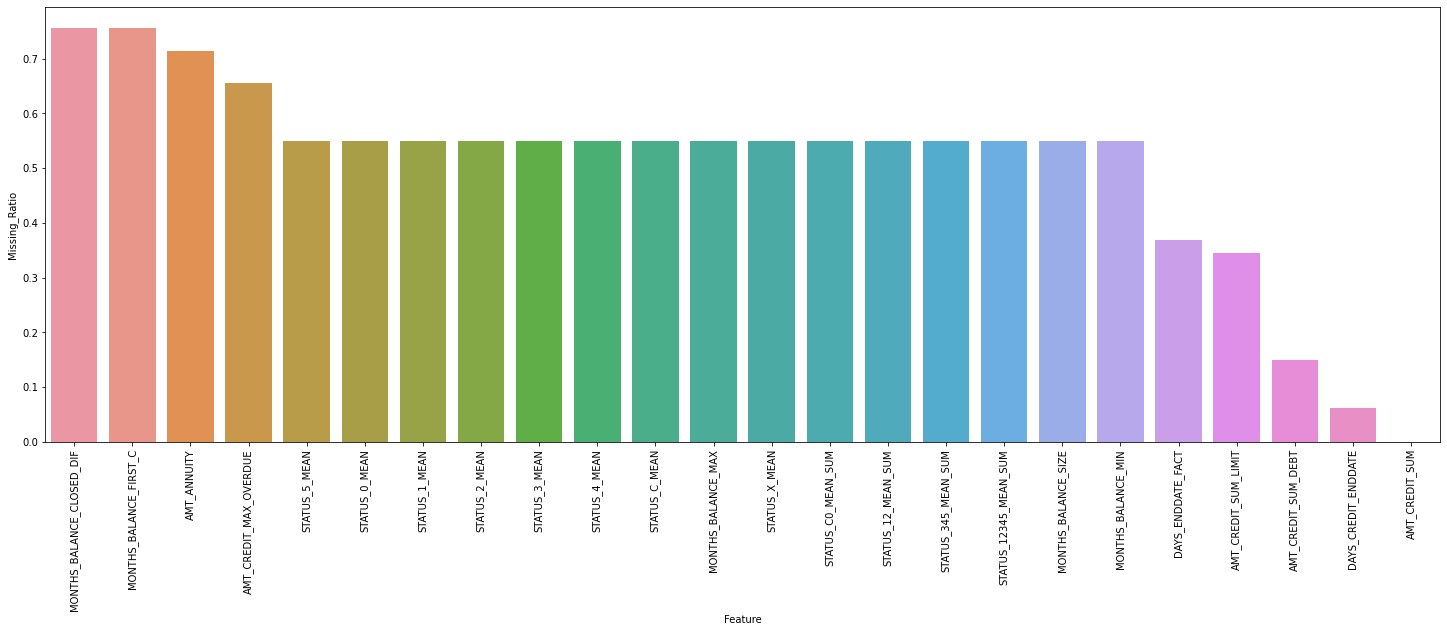

                      Feature  Num_Missing  Missing_Ratio DataTypes
0   MONTHS_BALANCE_CLOSED_DIF      1299036       0.756825   float64
1      MONTHS_BALANCE_FIRST_C      1299036       0.756825   float64
2                 AMT_ANNUITY      1226791       0.714735   float32
3      AMT_CREDIT_MAX_OVERDUE      1124488       0.655133   float32
4               STATUS_5_MEAN       942074       0.548857   float64
5               STATUS_0_MEAN       942074       0.548857   float64
6               STATUS_1_MEAN       942074       0.548857   float64
7               STATUS_2_MEAN       942074       0.548857   float64
8               STATUS_3_MEAN       942074       0.548857   float64
9               STATUS_4_MEAN       942074       0.548857   float64
10              STATUS_C_MEAN       942074       0.548857   float64
11         MONTHS_BALANCE_MAX       942074       0.548857   float64
12              STATUS_X_MEAN       942074       0.548857   float64
13         STATUS_C0_MEAN_SUM       942074      

In [23]:
# missing values
bureau_missing = missing_values(bureau, plot = True)

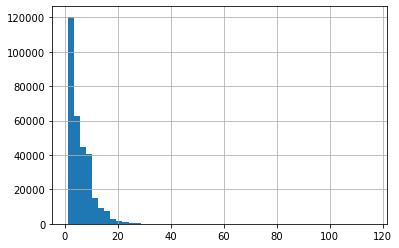

std         4.430354
max       116.000000
median      4.000000
mean        5.612709
min         1.000000
Name: SK_ID_BUREAU, dtype: float64

In [24]:
# le nombre de prêts que chaque client a dans le bureau de crédit
bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().hist(bins=50), plt.show()
bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().agg({"min", "max", "mean", "median", "std"})

In [25]:
# les variables peuvent être d'un type différent de ce qu'elles sont
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(bureau, car_th=10)

print("")

# Categorical Features
print(cat_cols, cat_but_car)

Observations: 1716428
Variables: 34
date_cols: 0
cat_cols: 2
num_cols: 29
cat_but_car: 1
num_but_cat: 0

['CREDIT_ACTIVE', 'CREDIT_CURRENCY'] ['CREDIT_TYPE']


In [26]:
# Cat Analyzer
for i in cat_cols + cat_but_car:
    cat_analyzer(bureau, i)

CREDIT_ACTIVE
            COUNT     RATIO
Closed    1079273  0.628790
Active     630607  0.367395
Sold         6527  0.003803
Bad debt       21  0.000012


CREDIT_CURRENCY
              COUNT     RATIO
currency 1  1715020  0.999180
currency 2     1224  0.000713
currency 3      174  0.000101
currency 4       10  0.000006


CREDIT_TYPE
                                                COUNT         RATIO
Consumer credit                               1251615  7.291975e-01
Credit card                                    402195  2.343209e-01
Car loan                                        27690  1.613234e-02
Mortgage                                        18391  1.071469e-02
Microloan                                       12413  7.231879e-03
Loan for business development                    1975  1.150645e-03
Another type of loan                             1017  5.925096e-04
Unknown type of loan                              555  3.233459e-04
Loan for working capital replenishment            46

Après les résultats de cat_analyzer :
- Je pense que la variable CREDIT_CURRENCY est inutile pour la modélisation. Presque toutes les lignes sont de catégorie devise 1.
- La variable CREDIT_ACTIVE peut être utile. Il y a deux catégories rares dans cette colonne. Nous pouvons combiner ces deux catégories afin d'attribuer une nouvelle catégorie en tant que Sold_BadDebt. En bref, la variable CREDIT_ACTIVE comprend 3 catégories comme Active, Closed et Sold_BadDebt.
- CREDIT_TYPE peut être utile, mais il existe également des catégories rares. Nous allons réduire le nombre de catégories.

In [27]:
# garbage collection  
gc.collect()

13297

### Data Manipulation & Feature Engineering for Bureau

In [28]:
# FEATURE ENGINEERING FOR BUREAU

# Categorical Variables
# -----------------------------------------------------------
# Useless
bureau.drop("CREDIT_CURRENCY", axis = 1, inplace = True)

# Rare Categories
bureau["CREDIT_ACTIVE"] = np.where(bureau.CREDIT_ACTIVE.isin(["Sold", "Bad debt"]), "Sold_BadDebt", bureau.CREDIT_ACTIVE)

bureau["CREDIT_TYPE"] = np.where(
    ~bureau.CREDIT_TYPE.isin(
        ["Consumer credit", "Credit card", "Car loan", "Mortgage", "Microloan"]
    ), "Other", bureau["CREDIT_TYPE"])

# One-Hot Encoder
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=False)


# Numerical Variables
# -----------------------------------------------------------

# Bureau and bureau_balance numeric features
cal = ['min', 'max', 'mean', 'sum', 'median','std']
cols1 = [
    'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_CREDIT_UPDATE','CREDIT_DAY_OVERDUE',
    'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE',
    'AMT_CREDIT_SUM_LIMIT', 'AMT_ANNUITY', 'CNT_CREDIT_PROLONG', 'MONTHS_BALANCE_MIN',
    'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_SIZE', 'MONTHS_BALANCE_FIRST_C', 'MONTHS_BALANCE_CLOSED_DIF'
]

num_aggregations = {}


for i in cols1:
    num_aggregations[i] = cal
    
    
# Bureau and bureau_balance categorical features
cat_aggregations = {}

for i in bureau_cat:
    cat_aggregations[i] = ['mean']

cols2 = ['STATUS_0_MEAN', 'STATUS_1_MEAN', 'STATUS_2_MEAN', 'STATUS_3_MEAN', 'STATUS_4_MEAN',
        'STATUS_5_MEAN', 'STATUS_C_MEAN', 'STATUS_X_MEAN', 'STATUS_C0_MEAN_SUM',
        'STATUS_12_MEAN_SUM', 'STATUS_345_MEAN_SUM', 'STATUS_12345_MEAN_SUM']
for i in cols2:
    cat_aggregations[i] = ['mean', 'median', 'sum', 'max', 'std']

del i, cols1, cols2, bureau_cat, cal
    
# Create aggregated data
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])


# New features
bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().value_counts()
bcount = bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().reset_index().rename({"SK_ID_BUREAU":"BUREAU_COUNT"}, axis = 1)
bcount["BUREAU_COUNT_CAT"] = np.where(bcount.BUREAU_COUNT < 4, 0, 1)
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 8) & (bcount.BUREAU_COUNT < 13), 2, bcount["BUREAU_COUNT_CAT"])
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 13) & (bcount.BUREAU_COUNT < 20), 3, bcount["BUREAU_COUNT_CAT"])
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 20), 4, bcount["BUREAU_COUNT_CAT"])
bureau_agg = pd.merge(bureau_agg, bcount, how = "left", on = "SK_ID_CURR")
del bcount


# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = pd.merge(bureau_agg, active_agg, how='left', on='SK_ID_CURR')
del active, active_agg


# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = pd.merge(bureau_agg, closed_agg, how='left', on='SK_ID_CURR')
del closed, closed_agg

# Bureau: Sold and Bad Debt credits - using only numerical aggregations
sold_baddebt = bureau[bureau['CREDIT_ACTIVE_Sold_BadDebt'] == 1]
sold_baddebt_agg = sold_baddebt.groupby('SK_ID_CURR').agg(num_aggregations)
sold_baddebt_agg.columns = pd.Index(['SOLD_BADDEBT' + e[0] + "_" + e[1].upper() for e in sold_baddebt_agg.columns.tolist()])
bureau_agg = pd.merge(bureau_agg, sold_baddebt_agg, how='left', on='SK_ID_CURR')
del sold_baddebt, sold_baddebt_agg, bureau

del num_aggregations, cat_aggregations




print("BUREAU & BUREAU BALANCE SHAPE:", bureau_agg.shape, "\n")

bureau_agg.head()

BUREAU & BUREAU BALANCE SHAPE: (305811, 456) 



,SK_ID_CURR,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_SUM,BUREAU_DAYS_CREDIT_MEDIAN,BUREAU_DAYS_CREDIT_STD,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_SUM,BUREAU_DAYS_CREDIT_ENDDATE_MEDIAN,BUREAU_DAYS_CREDIT_ENDDATE_STD,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_DAYS_CREDIT_UPDATE_MAX,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_SUM,BUREAU_DAYS_CREDIT_UPDATE_MEDIAN,BUREAU_DAYS_CREDIT_UPDATE_STD,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_SUM,BUREAU_CREDIT_DAY_OVERDUE_MEDIAN,BUREAU_CREDIT_DAY_OVERDUE_STD,BUREAU_AMT_CREDIT_MAX_OVERDUE_MIN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_SUM,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEDIAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_STD,BUREAU_AMT_CREDIT_SUM_MIN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_MEDIAN,BUREAU_AMT_CREDIT_SUM_STD,BUREAU_AMT_CREDIT_SUM_DEBT_MIN,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MEDIAN,BUREAU_AMT_CREDIT_SUM_DEBT_STD,BUREAU_AMT_CREDIT_SUM_OVERDUE_MIN,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEDIAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_STD,BUREAU_AMT_CREDIT_SUM_LIMIT_MIN,BUREAU_AMT_CREDIT_SUM_LIMIT_MAX,BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN,BUREAU_AMT_CREDIT_SUM_LIMIT_SUM,BUREAU_AMT_CREDIT_SUM_LIMIT_MEDIAN,BUREAU_AMT_CREDIT_SUM_LIMIT_STD,BUREAU_AMT_ANNUITY_MIN,BUREAU_AMT_ANNUITY_MAX,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AMT_ANNUITY_SUM,BUREAU_AMT_ANNUITY_MEDIAN,BUREAU_AMT_ANNUITY_STD,BUREAU_CNT_CREDIT_PROLONG_MIN,BUREAU_CNT_CREDIT_PROLONG_MAX,BUREAU_CNT_CREDIT_PROLONG_MEAN,BUREAU_CNT_CREDIT_PROLONG_SUM,BUREAU_CNT_CREDIT_PROLONG_MEDIAN,BUREAU_CNT_CREDIT_PROLONG_STD,BUREAU_MONTHS_BALANCE_MIN_MIN,BUREAU_MONTHS_BALANCE_MIN_MAX,BUREAU_MONTHS_BALANCE_MIN_MEAN,BUREAU_MONTHS_BALANCE_MIN_SUM,BUREAU_MONTHS_BALANCE_MIN_MEDIAN,BUREAU_MONTHS_BALANCE_MIN_STD,BUREAU_MONTHS_BALANCE_MAX_MIN,BUREAU_MONTHS_BALANCE_MAX_MAX,BUREAU_MONTHS_BALANCE_MAX_MEAN,BUREAU_MONTHS_BALANCE_MAX_SUM,BUREAU_MONTHS_BALANCE_MAX_MEDIAN,BUREAU_MONTHS_BALANCE_MAX_STD,BUREAU_MONTHS_BALANCE_SIZE_MIN,BUREAU_MONTHS_BALANCE_SIZE_MAX,BUREAU_MONTHS_BALANCE_SIZE_MEAN,BUREAU_MONTHS_BALANCE_SIZE_SUM,BUREAU_MONTHS_BALANCE_SIZE_MEDIAN,BUREAU_MONTHS_BALANCE_SIZE_STD,BUREAU_MONTHS_BALANCE_FIRST_C_MIN,BUREAU_MONTHS_BALANCE_FIRST_C_MAX,BUREAU_MONTHS_BALANCE_FIRST_C_MEAN,BUREAU_MONTHS_BALANCE_FIRST_C_SUM,BUREAU_MONTHS_BALANCE_FIRST_C_MEDIAN,BUREAU_MONTHS_BALANCE_FIRST_C_STD,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MIN,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MAX,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MEAN,BUREAU_MONTHS_BALANCE_CLOSED_DIF_SUM,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MEDIAN,BUREAU_MONTHS_BALANCE_CLOSED_DIF_STD,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Sold_BadDebt_MEAN,BUREAU_CREDIT_TYPE_Car loan_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_CREDIT_TYPE_Mortgage_MEAN,BUREAU_CREDIT_TYPE_Other_MEAN,BUREAU_STATUS_0_MEAN_MEAN,BUREAU_STATUS_0_MEAN_MEDIAN,BUREAU_STATUS_0_MEAN_SUM,BUREAU_STATUS_0_MEAN_MAX,BUREAU_STATUS_0_MEAN_STD,BUREAU_STATUS_1_MEAN_MEAN,BUREAU_STATUS_1_MEAN_MEDIAN,BUREAU_STATUS_1_MEAN_SUM,BUREAU_STATUS_1_MEAN_MAX,BUREAU_STATUS_1_MEAN_STD,BUREAU_STATUS_2_MEAN_MEAN,BUREAU_STATUS_2_MEAN_MEDIAN,BUREAU_STATUS_2_MEAN_SUM,BUREAU_STATUS_2_MEAN_MAX,BUREAU_STATUS_2_MEAN_STD,BUREAU_STATUS_3_MEAN_MEAN,BUREAU_STATUS_3_MEAN_MEDIAN,BUREAU_STATUS_3_MEAN_SUM,BUREAU_STATUS_3_MEAN_MAX,BUREAU_STATUS_3_MEAN_STD,BUREAU_STATUS_4_MEAN_MEAN,BUREAU_STATUS_4_MEAN_MEDIAN,BUREAU_STATUS_4_MEAN_SUM,BUREAU_STATUS_4_MEAN_MAX,BUREAU_STATUS_4_MEAN_STD,BUREAU_STATUS_5_MEAN_MEAN,BUREAU_STATUS_5_MEAN_MEDIA

# Pos Cash Balance

* Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur avait avec Home Credit.
* Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon 



In [29]:
# les variables peuvent être d'un type différent de ce qu'elles sont
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(pos, car_th=10)

print("")

pos.head()

Observations: 10001358
Variables: 8
date_cols: 0
cat_cols: 1
num_cols: 5
cat_but_car: 0
num_but_cat: 0



,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [30]:
# missing values
missing_val = missing_values(pos, plot = False)

Number of Variables include Missing Values: 2 

                 Feature  Num_Missing  Missing_Ratio DataTypes
0  CNT_INSTALMENT_FUTURE        26087       0.002608   float16
1         CNT_INSTALMENT        26071       0.002607   float16 



In [31]:
# Cat Analyzer
cat_analyzer(pos, "NAME_CONTRACT_STATUS")

NAME_CONTRACT_STATUS
                         COUNT         RATIO
Active                 9151119  9.149876e-01
Completed               744883  7.447819e-02
Signed                   87260  8.724815e-03
Demand                    7065  7.064041e-04
Returned to the store     5461  5.460258e-04
Approved                  4917  4.916332e-04
Amortized debt             636  6.359136e-05
Canceled                    15  1.499796e-06
XNA                          2  1.999728e-07




### Data Manipulation & Feature Engineering for Pos Cash Balance

In [32]:
# Rare
pos["NAME_CONTRACT_STATUS"] = np.where(~(pos["NAME_CONTRACT_STATUS"].isin([
   "Active", "Completed"
])), "Rare", pos["NAME_CONTRACT_STATUS"])

# One-Hot Encoder
pos, cat_cols = one_hot_encoder(pos, nan_as_category=False)

aggregations = {
    # Numerical
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'CNT_INSTALMENT': ['max', 'mean', 'std', 'min', 'median'],
    'CNT_INSTALMENT_FUTURE': ['max', 'mean', 'sum', 'min', 'median', 'std'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
# Categorical
for cat in cat_cols:
    aggregations[cat] = ['mean']

# Aggregation
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
pos_agg.reset_index(inplace = True)
del pos

print("POS CASH BALANCE SHAPE:", pos_agg.shape, "\n")

pos_agg.head()

POS CASH BALANCE SHAPE: (337252, 23) 



,SK_ID_CURR,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_STD,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MEDIAN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MEDIAN,POS_CNT_INSTALMENT_FUTURE_STD,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Rare_MEAN,POS_COUNT
0,100001,-53,-72.555556,9,4.0,4.000000,0.000000,4.0,4.0,4.0,1.444336,13.0,0.0,1.0,1.424001,7,0.777778,7,0.777778,0.777778,0.222222,0.000000,9
1,100002,-1,-10.000000,19,24.0,24.000000,0.000000,24.0,24.0,24.0,15.000000,285.0,6.0,15.0,5.627314,0,0.000000,0,0.000000,1.000000,0.000000,0.000000,19
2,100003,-18,-43.785714,28,12.0,10.109375,2.806597,6.0,12.0,12.0,5.785156,162.0,0.0,6.0,3.842811,0,0.000000,0,0.000000,0.928571,0.071429,0.000000,28
3,100004,-24,-25.500000,4,4.0,3.750000,0.500000,3.0,4.0,4.0,2.250000,9.0,0.0,2.5,1.707825,0,0.000000,0,0.000000,0.750000,0.250000,0.000000,4
4,100005,-15,-20.000000,11,12.0,11.703125,0.948683,9.0,12.0,12.0,7.199219,72.0,0.0,7.5,3.614784,0,0.000000,0,0.000000,0.818182,0.090909,0.090909,11


# Credit Card Balance

- Instantanés mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit.
- Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon 

In [33]:
# les variables peuvent être d'un type différent de ce qu'elles sont

cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(cc, car_th=10)
print("")
cc.head()

Observations: 3840312
Variables: 23
date_cols: 0
cat_cols: 1
num_cols: 18
cat_but_car: 0
num_but_cat: 0



,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,1800.0,1800.0,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,2250.0,2250.0,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,2250.0,2250.0,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,11925.0,11925.0,224949.281250,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,27000.0,27000.0,443044.406250,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [34]:
#missing values
missing_val = missing_values(cc, plot = False)

Number of Variables include Missing Values: 9 

                      Feature  Num_Missing  Missing_Ratio DataTypes
0         AMT_PAYMENT_CURRENT       767988       0.199981   float32
1    AMT_DRAWINGS_ATM_CURRENT       749816       0.195249   float32
2    CNT_DRAWINGS_POS_CURRENT       749816       0.195249   float16
3  AMT_DRAWINGS_OTHER_CURRENT       749816       0.195249   float32
4    AMT_DRAWINGS_POS_CURRENT       749816       0.195249   float32
5  CNT_DRAWINGS_OTHER_CURRENT       749816       0.195249   float16
6    CNT_DRAWINGS_ATM_CURRENT       749816       0.195249   float16
7   CNT_INSTALMENT_MATURE_CUM       305236       0.079482   float16
8     AMT_INST_MIN_REGULARITY       305236       0.079482   float32 



In [35]:
# Cat Analyzer
cat_analyzer(cc, "NAME_CONTRACT_STATUS")

NAME_CONTRACT_STATUS
                 COUNT     RATIO
Active         3698436  0.963056
Completed       128918  0.033570
Signed           11058  0.002879
Demand            1365  0.000355
Sent proposal      513  0.000134
Refused             17  0.000004
Approved             5  0.000001




### Data Manipulation & Feature Engineering for Credit Card Balance

In [36]:
# Rare
cc["NAME_CONTRACT_STATUS"] = np.where(~(cc["NAME_CONTRACT_STATUS"].isin([
   "Active", "Completed"
])), "Rare", cc["NAME_CONTRACT_STATUS"])

# One Hot Encoder
cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)

# General aggregations
cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'std'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
cc_agg.reset_index(inplace = True)
del cc

print("CREDIT CARD BALANCE SHAPE:", cc_agg.shape, "\n")

cc_agg.head()

CREDIT CARD BALANCE SHAPE: (103558, 117) 



,SK_ID_CURR,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_STD,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_STD,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_STD,CC_AMT_DRAWINGS_ATM_CURRENT_MIN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_ATM_CURRENT_STD,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_STD,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_STD,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_POS_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_STD,CC_AMT_INST_MIN_REGULARITY_MIN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_AMT_INST_MIN_REGULARITY_MEAN,CC_AMT_INST_MIN_REGULARITY_SUM,CC_AMT_INST_MIN_REGULARITY_STD,CC_AMT_PAYMENT_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_MAX,CC_AMT_PAYMENT_CURRENT_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_PAYMENT_CURRENT_STD,CC_AMT_PAYMENT_TOTAL_CURRENT_MIN,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_STD,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_STD,CC_AMT_RECIVABLE_MIN,CC_AMT_RECIVABLE_MAX,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECIVABLE_SUM,CC_AMT_RECIVABLE_STD,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_TOTAL_RECEIVABLE_SUM,CC_AMT_TOTAL_RECEIVABLE_STD,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_STD,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_STD,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_STD,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_STD,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_STD,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_STD,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_STD,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_STD,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_STD,CC_NAME_CONTRACT_STATUS_Rare_MIN,CC_NAME_CONTRACT_STATUS_Rare_MAX,CC_NAME_CONTRACT_STATUS_Rare_MEAN,CC_NAME_CONTRACT_STATUS_Rare_SUM,CC_NAME_CONTRACT_STATUS_Rare_STD,CC_COUNT
0,100006,-6,-1,-3.5,-21.0,1.870829,0.0,0.00000,0.000000,0.00,0.000000,270000,270000,270000.000000,1620000,0.000000,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.00,NaN,0.0,0.0,0.000000,0.0000,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.000,0.000000,0.000000,0.00000,0.000000,0.000,0.000000,NaN,NaN,NaN,0.0,NaN,0,0,0.000000,0,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.000000,0.0,0.000000,0,0,0.000000,0.0,0.000000,0,0,0.000000,0.0,0.000000,1,1,1.000000,6,0.0000,0,0,0.000000,0,0.0000,0,0,

#  Installments Payments

- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [37]:

# les variables peuvent être d'un type différent de ce qu'elles sont
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(ins, car_th=10)

print("")
ins.head()

Observations: 13605401
Variables: 8
date_cols: 0
cat_cols: 0
num_cols: 5
cat_but_car: 0
num_but_cat: 0



,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [38]:
# missing values
missing_val = missing_values(ins, plot = False)

Number of Variables include Missing Values: 2 

              Feature  Num_Missing  Missing_Ratio DataTypes
0  DAYS_ENTRY_PAYMENT         2905       0.000214   float16
1         AMT_PAYMENT         2905       0.000214   float32 



### Data Manipulation & Feature Engineering for Installments Payments

In [39]:
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'NUM_INSTALMENT_NUMBER': ['max', 'mean', 'sum', 'median', 'std'],
    'DAYS_INSTALMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum', 'median', 'std'],
    'DPD': ['max', 'mean', 'sum', 'median', 'std'],
    'DBD': ['max', 'mean', 'sum', 'median', 'std'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'std', 'median'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'std', 'median']
}

ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INS_COUNT'] = ins.groupby('SK_ID_CURR').size()

ins_agg.reset_index(inplace = True)
del ins



print("INSTALLMENTS PAYMENTS SHAPE:", ins_agg.shape, "\n")

ins_agg.head()

INSTALLMENTS PAYMENTS SHAPE: (339587, 49) 



,SK_ID_CURR,INS_NUM_INSTALMENT_VERSION_NUNIQUE,INS_NUM_INSTALMENT_NUMBER_MAX,INS_NUM_INSTALMENT_NUMBER_MEAN,INS_NUM_INSTALMENT_NUMBER_SUM,INS_NUM_INSTALMENT_NUMBER_MEDIAN,INS_NUM_INSTALMENT_NUMBER_STD,INS_DAYS_INSTALMENT_MAX,INS_DAYS_INSTALMENT_MEAN,INS_DAYS_INSTALMENT_SUM,INS_DAYS_INSTALMENT_MEDIAN,INS_DAYS_INSTALMENT_STD,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DAYS_ENTRY_PAYMENT_MEAN,INS_DAYS_ENTRY_PAYMENT_SUM,INS_DAYS_ENTRY_PAYMENT_MEDIAN,INS_DAYS_ENTRY_PAYMENT_STD,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_SUM,INS_AMT_INSTALMENT_MEDIAN,INS_AMT_INSTALMENT_STD,INS_AMT_PAYMENT_MIN,INS_AMT_PAYMENT_MAX,INS_AMT_PAYMENT_MEAN,INS_AMT_PAYMENT_SUM,INS_AMT_PAYMENT_MEDIAN,INS_AMT_PAYMENT_STD,INS_DPD_MAX,INS_DPD_MEAN,INS_DPD_SUM,INS_DPD_MEDIAN,INS_DPD_STD,INS_DBD_MAX,INS_DBD_MEAN,INS_DBD_SUM,INS_DBD_MEDIAN,INS_DBD_STD,INS_PAYMENT_PERC_MAX,INS_PAYMENT_PERC_MEAN,INS_PAYMENT_PERC_SUM,INS_PAYMENT_PERC_STD,INS_PAYMENT_PERC_MEDIAN,INS_PAYMENT_DIFF_MAX,INS_PAYMENT_DIFF_MEAN,INS_PAYMENT_DIFF_SUM,INS_PAYMENT_DIFF_STD,INS_PAYMENT_DIFF_MEDIAN,INS_COUNT
0,100001,2,4,2.714286,19.0,3.0,1.112697,-1619.0,-2188.0,-15312.0,-1709.0,653.989733,-1628.0,-2196.0,-15368.0,-1715.0,644.080334,17397.900391,5885.132324,4.119593e+04,3980.925049,5076.676763,3951.000000,17397.900391,5885.132324,4.119593e+04,3980.925049,5076.676763,10.0,1.428571,10.0,0.0,3.779645,36.0,8.857143,62.0,6.0,12.811825,1.0,1.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7
1,100002,2,19,10.000000,190.0,10.0,5.627314,-25.0,-295.0,-5604.0,-295.0,168.819430,-49.0,-315.5,-5992.0,-312.0,172.058877,53093.746094,11559.247070,2.196257e+05,9251.775391,10058.037883,9251.775391,53093.746094,11559.247070,2.196257e+05,9251.775391,10058.037883,0.0,0.000000,0.0,0.0,0.000000,31.0,20.421053,388.0,19.0,4.925171,1.0,1.0,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,19
2,100003,2,12,5.080000,127.0,5.0,3.134751,-536.0,-1378.0,-34464.0,-797.0,757.453556,-544.0,-1385.0,-34624.0,-806.0,757.368409,560835.375000,64754.585938,1.618865e+06,64275.613281,110542.594872,6662.970215,560835.375000,64754.585938,1.618865e+06,64275.613281,110542.594872,0.0,0.000000,0.0,0.0,0.000000,14.0,7.200000,180.0,6.0,3.719319,1.0,1.0,25.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,25
3,100004,2,3,2.000000,6.0,2.0,1.000000,-724.0,-754.0,-2262.0,-754.0,30.000000,-727.0,-761.5,-2284.0,-763.0,34.019602,10573.964844,7096.154785,2.128846e+04,5357.250000,3011.871719,5357.250000,10573.964844,7096.154785,2.128846e+04,5357.250000,3011.871719,0.0,0.000000,0.0,0.0,0.000000,11.0,7.666667,23.0,9.0,4.163332,1.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3
4,100005,2,9,5.000000,45.0,5.0,2.738613,-466.0,-586.0,-5272.0,-586.0,82.158384,-470.0,-609.5,-5488.0,-585.0,90.554005,17656.244141,6240.205078,5.616184e+04,4813.200195,4281.014648,4813.200195,17656.244141,6240.205078,5.616184e+04,4813.200195,4281.014648,1.0,0.111111,1.0,0.0,0.333333,37.0,23.666667,213.0,29.0,13.285330,1.0,1.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9


#  Previous Applications

* Toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon.
* Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

In [40]:
# les variables peuvent être d'un type différent de ce qu'elles sont

cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(prev, car_th=10)
print("")
print(cat_but_car, num_but_cat)
prev.head()

Observations: 1670214
Variables: 37
date_cols: 0
cat_cols: 13
num_cols: 15
cat_but_car: 4
num_but_cat: 1

['NAME_CASH_LOAN_PURPOSE', 'NAME_GOODS_CATEGORY', 'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION'] ['NFLAG_LAST_APPL_IN_DAY']


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182861,0.867188,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Cat Analyzer  - on va prendre en compte, en cas de nécessité, toutes les informations reçues
for i in cat_cols + cat_but_car + num_but_cat:
    cat_analyzer(prev, i)

NAME_CONTRACT_TYPE
                  COUNT     RATIO
Cash loans       747553  0.447579
Consumer loans   729151  0.436561
Revolving loans  193164  0.115652
XNA                 346  0.000207


WEEKDAY_APPR_PROCESS_START
            COUNT     RATIO
TUESDAY    255118  0.152746
WEDNESDAY  255010  0.152681
MONDAY     253557  0.151811
FRIDAY     252048  0.150908
THURSDAY   249099  0.149142
SATURDAY   240631  0.144072
SUNDAY     164751  0.098641


FLAG_LAST_APPL_PER_CONTRACT
     COUNT     RATIO
Y  1661739  0.994926
N     8475  0.005074


NAME_CONTRACT_STATUS
                COUNT     RATIO
Approved      1036781  0.620747
Canceled       316319  0.189388
Refused        290678  0.174036
Unused offer    26436  0.015828


NAME_PAYMENT_TYPE
                                             COUNT     RATIO
Cash through the bank                      1033552  0.618814
XNA                                         627384  0.375631
Non-cash from your account                    8193  0.004905
Cashless from the 

In [42]:
# missing values
missing_val = missing_values(prev, plot = False)

Number of Variables include Missing Values: 16 

                      Feature  Num_Missing  Missing_Ratio DataTypes
0    RATE_INTEREST_PRIVILEGED      1664263   9.964370e-01   float16
1       RATE_INTEREST_PRIMARY      1664263   9.964370e-01   float16
2            AMT_DOWN_PAYMENT       895844   5.363648e-01   float32
3           RATE_DOWN_PAYMENT       895844   5.363648e-01   float16
4             NAME_TYPE_SUITE       820405   4.911975e-01    object
5   NFLAG_INSURED_ON_APPROVAL       673065   4.029813e-01   float16
6            DAYS_TERMINATION       673065   4.029813e-01   float32
7               DAYS_LAST_DUE       673065   4.029813e-01   float32
8   DAYS_LAST_DUE_1ST_VERSION       673065   4.029813e-01   float32
9              DAYS_FIRST_DUE       673065   4.029813e-01   float32
10         DAYS_FIRST_DRAWING       673065   4.029813e-01   float32
11            AMT_GOODS_PRICE       385515   2.308177e-01   float32
12                AMT_ANNUITY       372235   2.228667e-01   float32

### Data Manipulation & Feature Engineering for Previous Applications

In [43]:
# Rare Encoder
rare_cols = [
    "NAME_PAYMENT_TYPE", "CODE_REJECT_REASON", "CHANNEL_TYPE", "NAME_GOODS_CATEGORY",
    "NAME_SELLER_INDUSTRY", "NAME_TYPE_SUITE"
]

for i in rare_cols:
    rare_encoder(prev, i, rare_perc = 0.01)

prev["NAME_CASH_LOAN_PURPOSE"] = np.where(~prev["NAME_CASH_LOAN_PURPOSE"].isin(["XAP", "XNA"]), "Other", prev["NAME_CASH_LOAN_PURPOSE"])

rare_encoder(prev, "NAME_PORTFOLIO", rare_perc = 0.1) 

# Cash, Pos, Card
prev["PRODUCT_COMBINATION_CATS"] = np.where(prev["PRODUCT_COMBINATION"].str.contains("Cash"), "CASH", "POS")
prev["PRODUCT_COMBINATION_CATS"] = np.where(prev["PRODUCT_COMBINATION"].str.contains("Card"), "CARD", prev["PRODUCT_COMBINATION_CATS"])
# New categorical variables
prev["PRODUCT_COMBINATION_POS_WITH"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") & (prev["PRODUCT_COMBINATION"].str.contains("without"))), "WITHOUT", "OTHER")
prev["PRODUCT_COMBINATION_POS_WITH"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") & (prev["PRODUCT_COMBINATION"].str.contains("with interest"))), "WITH", prev["PRODUCT_COMBINATION_POS_WITH"])
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") & (prev["PRODUCT_COMBINATION"].str.contains("household"))), "household", "OTHER")
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") & (prev["PRODUCT_COMBINATION"].str.contains("industry"))), "industry", prev["PRODUCT_COMBINATION_POS_TYPE"])
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") & (prev["PRODUCT_COMBINATION"].str.contains("mobile"))), "mobile", prev["PRODUCT_COMBINATION_POS_TYPE"])
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") & (prev["PRODUCT_COMBINATION"].str.contains("other"))), "posother", prev["PRODUCT_COMBINATION_POS_TYPE"])
prev["PRODUCT_COMBINATION_CASH_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("Cash") & (prev["PRODUCT_COMBINATION"].str.contains("X-Sell"))), "xsell", "OTHER")
prev["PRODUCT_COMBINATION_CASH_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("Cash") & (prev["PRODUCT_COMBINATION"].str.contains("Street"))), "street", prev["PRODUCT_COMBINATION_CASH_TYPE"])


# Useless
prev.drop(["WEEKDAY_APPR_PROCESS_START", "FLAG_LAST_APPL_PER_CONTRACT", "NFLAG_LAST_APPL_IN_DAY", "NFLAG_LAST_APPL_IN_DAY"], axis = 1, inplace = True)

# One-Hot Encoder
prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)


# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']


# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean', "median", "std"],
    'AMT_APPLICATION': ['min', 'max', 'mean', "median", "std"],
    'AMT_CREDIT': ['min', 'max', 'mean', "median", "std"],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', "median", "std"],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', "median", "std"],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean', "median", "std"],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean', "median", "std"],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean', "std"],
    'RATE_INTEREST_PRIMARY': ['min', 'max', 'mean', "std"],
    'RATE_INTEREST_PRIVILEGED': ['min', 'max', 'mean', "std"],
    'DAYS_DECISION': ['min', 'max', 'mean', "median", "std"],
    'CNT_PAYMENT': ['mean', 'sum', "median", "std"],
    'SELLERPLACE_AREA': ['min', 'max', 'mean', "median", "std"],
    'DAYS_FIRST_DRAWING': ['min', 'max', 'mean', "median", "std"],
    'DAYS_FIRST_DUE': ['min', 'max', 'mean', "median", "std"],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean', "median", "std"],
    'DAYS_LAST_DUE': ['min', 'max', 'mean', "median", "std"],
    'DAYS_TERMINATION': ['min', 'max', 'mean', "median", "std"],
    # Categorical
    "NFLAG_INSURED_ON_APPROVAL": ["mean"]
}
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = pd.merge(prev_agg,approved_agg, how='left', on='SK_ID_CURR')

# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = pd.merge(prev_agg, refused_agg, how='left', on='SK_ID_CURR')

del refused, refused_agg, approved, approved_agg, prev
prev_agg.reset_index(inplace = True)


print("PREVIOUS APPLICATIONS SHAPE:", prev_agg.shape, "\n")

prev_agg.head()

PREVIOUS APPLICATIONS SHAPE: (338857, 378) 



,SK_ID_CURR,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MEDIAN,PREV_AMT_ANNUITY_STD,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MEDIAN,PREV_AMT_APPLICATION_STD,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MEDIAN,PREV_AMT_CREDIT_STD,PREV_APP_CREDIT_PERC_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_MEDIAN,PREV_APP_CREDIT_PERC_STD,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MEDIAN,PREV_AMT_DOWN_PAYMENT_STD,PREV_AMT_GOODS_PRICE_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MEDIAN,PREV_AMT_GOODS_PRICE_STD,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_HOUR_APPR_PROCESS_START_MEDIAN,PREV_HOUR_APPR_PROCESS_START_STD,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_RATE_DOWN_PAYMENT_STD,PREV_RATE_INTEREST_PRIMARY_MIN,PREV_RATE_INTEREST_PRIMARY_MAX,PREV_RATE_INTEREST_PRIMARY_MEAN,PREV_RATE_INTEREST_PRIMARY_STD,PREV_RATE_INTEREST_PRIVILEGED_MIN,PREV_RATE_INTEREST_PRIVILEGED_MAX,PREV_RATE_INTEREST_PRIVILEGED_MEAN,PREV_RATE_INTEREST_PRIVILEGED_STD,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_DAYS_DECISION_MEDIAN,PREV_DAYS_DECISION_STD,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_CNT_PAYMENT_MEDIAN,PREV_CNT_PAYMENT_STD,PREV_SELLERPLACE_AREA_MIN,PREV_SELLERPLACE_AREA_MAX,PREV_SELLERPLACE_AREA_MEAN,PREV_SELLERPLACE_AREA_MEDIAN,PREV_SELLERPLACE_AREA_STD,PREV_DAYS_FIRST_DRAWING_MIN,PREV_DAYS_FIRST_DRAWING_MAX,PREV_DAYS_FIRST_DRAWING_MEAN,PREV_DAYS_FIRST_DRAWING_MEDIAN,PREV_DAYS_FIRST_DRAWING_STD,PREV_DAYS_FIRST_DUE_MIN,PREV_DAYS_FIRST_DUE_MAX,PREV_DAYS_FIRST_DUE_MEAN,PREV_DAYS_FIRST_DUE_MEDIAN,PREV_DAYS_FIRST_DUE_STD,PREV_DAYS_LAST_DUE_1ST_VERSION_MIN,PREV_DAYS_LAST_DUE_1ST_VERSION_MAX,PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN,PREV_DAYS_LAST_DUE_1ST_VERSION_MEDIAN,PREV_DAYS_LAST_DUE_1ST_VERSION_STD,PREV_DAYS_LAST_DUE_MIN,PREV_DAYS_LAST_DUE_MAX,PREV_DAYS_LAST_DUE_MEAN,PREV_DAYS_LAST_DUE_MEDIAN,PREV_DAYS_LAST_DUE_STD,PREV_DAYS_TERMINATION_MIN,PREV_DAYS_TERMINATION_MAX,PREV_DAYS_TERMINATION_MEAN,PREV_DAYS_TERMINATION_MEDIAN,PREV_DAYS_TERMINATION_STD,PREV_NFLAG_INSURED_ON_APPROVAL_MEAN,PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_NAME_CONTRACT_TYPE_nan_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN,PREV_NAME_CONTRACT_STATUS_nan_MEAN,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN,PREV_NAME_PAYMENT_TYPE_Rare_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,PREV_NAME_PAYMENT_TYPE_nan_MEAN,PREV_CODE_REJECT_REASON_CLIENT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_Rare_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_CODE_REJECT_REASON_nan_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,PREV_NAME_TYPE_SUITE_Rare_MEAN,"PREV_NAME_TYPE_SUITE_Spouse, partner_MEAN",PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_Repeater_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_CLIENT_TYPE_nan_MEAN,PREV_NAME_GOODS_CATEGORY_Audio/Video_MEAN,PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN,PREV_NAME_GOODS_CATEGORY_Consumer Electronics_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_C

#  Application Train/Test

* Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
* Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

In [44]:

train = train.append(test)
df = train.copy()

# les variables peuvent être d'un type différent de ce qu'elles sont
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df, car_th=10)

print("")

df.head()

Observations: 356255
Variables: 122
date_cols: 0
cat_cols: 49
num_cols: 10
cat_but_car: 2
num_but_cat: 35



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.0,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.0,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.

### Data Manipulation & Feature Engineering for Application Train/Test

In [45]:
for i in cat_cols + cat_but_car + num_but_cat:
    cat_analyzer(df, i, target = "TARGET")

NAME_CONTRACT_TYPE
                  COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  \
Cash loans       326537  0.916582        278232     0.083459            0.0   
Revolving loans   29718  0.083418         29279     0.054783            0.0   

                 TARGET_STD  
Cash loans         0.276575  
Revolving loans    0.227561  


CODE_GENDER
      COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
F    235126  0.659994        202448     0.069993            0.0    0.255136
M    121125  0.339995        105059     0.101419            0.0    0.301884
XNA       4  0.000011             4     0.000000            0.0    0.000000


FLAG_OWN_CAR
    COUNT   RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
N  235235  0.6603        202924     0.085002            0.0    0.278886
Y  121020  0.3397        104587     0.072437            0.0    0.259212


FLAG_OWN_REALTY
    COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
N  109285  0

      COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
No   185607  0.520995        159428     0.069649            0.0    0.254555
Yes    2684  0.007534          2328     0.095790            0.0    0.294367


TARGET
      COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0.0  282686  0.793493        282686          0.0            0.0         0.0
1.0   24825  0.069683         24825          1.0            1.0         0.0


FLAG_MOBIL
    COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0       2  0.000006             1     0.000000            0.0         NaN
1  356253  0.999994        307510     0.080729            0.0    0.272419


FLAG_EMP_PHONE
    COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0   64661  0.181502         55386     0.054003            0.0    0.226025
1  291594  0.818498        252125     0.086600            0.0    0.281248


FLAG_WORK_PHONE
    COUNT     RATIO  TARGET_COUNT  TARGET_M

    COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0  356072  0.999486        307328     0.080738            0.0    0.272433
1     183  0.000514           183     0.065574            0.0    0.248215


FLAG_DOCUMENT_20
    COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0  356099  0.999562        307355     0.080727            0.0    0.272417
1     156  0.000438           156     0.083333            0.0    0.277276


FLAG_DOCUMENT_21
    COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0  356152  0.999711        307408     0.080710            0.0    0.272390
1     103  0.000289           103     0.135922            0.0    0.344382


OCCUPATION_TYPE
                       COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  \
Accountants            11441  0.032115          9813     0.048303   
Cleaning staff          5309  0.014902          4653     0.096067   
Cooking staff           6840  0.019200          5946     0.104440   
Co

      COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0.0  282686  0.793493        282686          0.0            0.0         0.0
1.0   24825  0.069683         24825          1.0            1.0         0.0


FLAG_MOBIL
    COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0       2  0.000006             1     0.000000            0.0         NaN
1  356253  0.999994        307510     0.080729            0.0    0.272419


FLAG_EMP_PHONE
    COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0   64661  0.181502         55386     0.054003            0.0    0.226025
1  291594  0.818498        252125     0.086600            0.0    0.281248


FLAG_WORK_PHONE
    COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0  284969  0.799902        246203     0.076851            0.0    0.266356
1   71286  0.200098         61308     0.096301            0.0    0.295006


FLAG_CONT_MOBILE
    COUNT    RATIO  TARGET_COUNT  TARGE

    COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0  356099  0.999562        307355     0.080727            0.0    0.272417
1     156  0.000438           156     0.083333            0.0    0.277276


FLAG_DOCUMENT_21
    COUNT     RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0  356152  0.999711        307408     0.080710            0.0    0.272390
1     103  0.000289           103     0.135922            0.0    0.344382




In [46]:
# missing values
missing_val = missing_values(df, plot = False)

Number of Variables include Missing Values: 68 

                         Feature  Num_Missing  Missing_Ratio DataTypes
0                 COMMONAREA_AVG       248360       0.697141   float16
1                COMMONAREA_MODE       248360       0.697141   float16
2                COMMONAREA_MEDI       248360       0.697141   float16
3        NONLIVINGAPARTMENTS_AVG       246861       0.692933   float16
4       NONLIVINGAPARTMENTS_MODE       246861       0.692933   float16
5       NONLIVINGAPARTMENTS_MEDI       246861       0.692933   float16
6             FONDKAPREMONT_MODE       243092       0.682354    object
7          LIVINGAPARTMENTS_MEDI       242979       0.682037   float16
8           LIVINGAPARTMENTS_AVG       242979       0.682037   float16
9          LIVINGAPARTMENTS_MODE       242979       0.682037   float16
10                 FLOORSMIN_AVG       241108       0.676785   float16
11                FLOORSMIN_MODE       241108       0.676785   float16
12                FLOORSMIN_

### Data Manipulation & Feature Engineering for Application Train/Test

In [47]:
# ERRORS
df = df[~(df.CODE_GENDER.str.contains("XNA"))]  
df = df[df.NAME_FAMILY_STATUS != "Unknown"]  

# DROP
cols = ["NAME_HOUSING_TYPE", "WEEKDAY_APPR_PROCESS_START", "FONDKAPREMONT_MODE", "WALLSMATERIAL_MODE", "HOUSETYPE_MODE",
        "EMERGENCYSTATE_MODE","FLAG_MOBIL", "FLAG_EMP_PHONE","FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL"]
df.drop(cols, axis = 1, inplace = True)

# REGION
cols = ["REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY",
 "REG_CITY_NOT_WORK_CITY","LIVE_CITY_NOT_WORK_CITY"]
df["REGION"] = df[cols].sum(axis = 1)
df.drop(cols, axis = 1, inplace = True)

# Drop FLAG_DOCUMENT 
df.drop(df.columns[df.columns.str.contains("FLAG_DOCUMENT")], axis = 1, inplace = True)


# RARE ENCODER
df["NAME_EDUCATION_TYPE"] = np.where(df.NAME_EDUCATION_TYPE == "Academic degree", "Higher education", df.NAME_EDUCATION_TYPE)


df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.str.contains("Business Entity"), "Business Entity", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.str.contains("Industry"), "Industry", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.str.contains("Trade"), "Trade", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.str.contains("Transport"), "Transport", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["School", "Kindergarten", "University"]), "Education", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Emergency","Police", "Medicine","Goverment", "Postal", "Military", "Security Ministries", "Legal Services"]), "Public", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Bank", "Insurance"]), "Finance", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Realtor", "Housing"]), "House", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Hotel", "Restaurant"]), "HotelRestaurant", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Cleaning","Electricity", "Telecom", "Mobile", "Advertising", "Religion", "Culture"]), "Other", df.ORGANIZATION_TYPE)

df["OCCUPATION_TYPE"] = np.where(df.OCCUPATION_TYPE.isin(["Low-skill Laborers", "Cooking staff", "Security staff", "Private service staff", "Cleaning staff", "Waiters/barmen staff"]), "Low-skill Laborers", df.OCCUPATION_TYPE)
df["OCCUPATION_TYPE"] = np.where(df.OCCUPATION_TYPE.isin(["IT staff", "High skill tech staff"]), "High skill tech staff", df.OCCUPATION_TYPE)


rare_cols = ["NAME_TYPE_SUITE", "NAME_INCOME_TYPE"]

for i in rare_cols:
    rare_encoder(df, i, rare_perc = 0.01)

    
# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ["NAME_CONTRACT_TYPE", 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])
    
    
# Categorical features with One-Hot encode
df, cat_cols = one_hot_encoder(df, nan_as_category=False)


# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# Some simple new features (percentages)
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']


# EXT SOURCE MEAN FROM OTHER ASSOCIATIONS 
df["NEW_EXT_MEAN"] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['NEW_APP_EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

# Le rapport entre le produit à acheter et le montant total du prêt
df["NEW_GOODS_CREDIT"] = df["AMT_GOODS_PRICE"] / df["AMT_CREDIT"]

# Rapport entre le paiement annuel du prêt et le revenu total du client
df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

# Le rapport de la différence entre le produit et le prêt sur le revenu annuel total
df["NEW_C_GP"] = (df["AMT_GOODS_PRICE"] - df["AMT_CREDIT"]) / df["AMT_INCOME_TOTAL"]


# Au moment de la demande, l'âge du client en jours est indiqué en moins
# Nous trouvons son âge en multipliant par -1 et en divisant par 365.

df["NEW_APP_AGE"] = round(df["DAYS_BIRTH"] * -1 / 365)

df['NEW_INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['NEW_PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

# kredinin çekildiği ürünün fiyatı / kredi miktarı
df["NEW_APP_GOODS/AMT_CREDIT"] = df["AMT_GOODS_PRICE"] / df["AMT_CREDIT"]

df['NEW_LOAN_VALUE_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']

df['NEW_DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

df['NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON'] = df['NEW_INCOME_PER_PERSON'] / df['NEW_PAYMENT_RATE']

print("APPLICATION TRAIN/TEST SHAPE:", df.shape, "\n")
df.head()

APPLICATION TRAIN/TEST SHAPE: (356249, 144) 



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Rare,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Rare,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Business Entity,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Finance,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_HotelRestaurant,ORGANIZATION_TYPE_House,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Public,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_APP_EXT_SOURCES_PROD,NEW_GOODS_CREDIT,NEW_ANNUITY_INCOME_PERC,NEW_C_GP,NEW_APP_AGE,NEW_INCOME_PER_PERSON,NEW_PAYMENT_RATE,NEW_APP_GOODS/AMT_CREDIT,NEW_LOAN_VALUE_RATIO,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON
0,100002,1.0,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018799,-9461,-637.0,-3648.0,-2120,NaN,1.0,2,2,10,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.0,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,0.014900,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.067329,0.498036,202500.0,0.121978,0.060749,0.161743,0.003042,0.863262,0.121978,-0.274556,26.0,202500.0,0.060749,0.863262,1.158397,0.067329,3.333374e+06
1,10

In [48]:
# recuperation de la table test
test = df[df['TARGET'].isna()]

In [49]:
test.shape

(48744, 144)

In [50]:
# recuperation de la dataset train
train = df[df['TARGET'].notna()]

In [51]:
train.shape

(307505, 144)

In [52]:
# garbage collection  
gc.collect()

20

## Merging All Tables

Nous allons maintenant fusionner toutes les tables prétraitées avec les tables application_train et application_test. Les fusions seront des jointures externes gauches, de sorte que toutes les applications actuelles sont préservées, car nous devons les modéliser.

In [53]:
application_train = reduce_mem_usage(train)
application_test = reduce_mem_usage(test)
application_test.drop(columns='TARGET', inplace=True)
bureau_aggregated = reduce_mem_usage(bureau_agg)
previous_aggregated = reduce_mem_usage(prev_agg)
installments_aggregated = reduce_mem_usage(ins_agg)
pos_aggregated = reduce_mem_usage(pos_agg)
cc_aggregated = reduce_mem_usage(cc_agg)

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 99.12 MB
Memory usage after optimization: 88.86 MB
Decreased by 10.4%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 15.71 MB
Memory usage after optimization: 14.36 MB
Decreased by 8.6%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 871.72 MB
Memory usage after optimization: 359.60 MB
Decreased by 58.7%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
M

In [54]:
del train, test,bureau_agg,prev_agg,ins_agg,pos_agg,cc_agg 

In [55]:
# garbage collection   
gc.collect()

323

In [56]:
app_train_merged = reduce_mem_usage(application_train.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'left'), verbose = True)

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 469.51 MB
Memory usage after optimization: 447.22 MB
Decreased by 4.7%
----------------------------------------------------------------------------------------------------


In [57]:
app_train_merged.shape

(307505, 599)

In [60]:
app_train_merged = reduce_mem_usage(app_train_merged.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'left'), verbose = True)

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 793.27 MB
Memory usage after optimization: 783.88 MB
Decreased by 1.2%
----------------------------------------------------------------------------------------------------


In [61]:
app_train_merged.shape

(307505, 976)

In [64]:
app_train_merged = reduce_mem_usage(app_train_merged.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'left'), verbose = True)

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 834.91 MB
Memory usage after optimization: 829.63 MB
Decreased by 0.6%
----------------------------------------------------------------------------------------------------


In [65]:
app_train_merged.shape

(307505, 1024)

In [68]:
app_train_merged = reduce_mem_usage(app_train_merged.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'left'), verbose = True)

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 851.33 MB
Memory usage after optimization: 842.53 MB
Decreased by 1.0%
----------------------------------------------------------------------------------------------------


In [69]:
app_train_merged.shape

(307505, 1046)

In [72]:
app_train_merged = reduce_mem_usage(app_train_merged.merge(cc_aggregated, on = 'SK_ID_CURR', how = 'left'), verbose = True)

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 966.29 MB
Memory usage after optimization: 945.18 MB
Decreased by 2.2%
----------------------------------------------------------------------------------------------------


In [73]:
app_train_merged.shape

(307505, 1162)

In [76]:
# Fonction de creation des nouvelles features 
def create_new_features(data):

    #previous applications columns
    prev_annuity_columns = [ele for ele in previous_aggregated.columns if 'AMT_ANNUITY' in ele]
    for col in prev_annuity_columns:
        data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    prev_goods_columns = [ele for ele in previous_aggregated.columns if 'AMT_GOODS' in ele]
    for col in prev_goods_columns:
        data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
  
    #credit_card_balance columns
    cc_amt_principal_cols = [ele for ele in cc_aggregated.columns if 'AMT_RECEIVABLE_PRINCIPAL' in ele]
    for col in cc_amt_principal_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    cc_amt_recivable_cols = [ele for ele in cc_aggregated.columns if 'AMT_RECIVABLE' in ele]
    for col in cc_amt_recivable_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    cc_amt_total_receivable_cols = [ele for ele in cc_aggregated.columns if 'TOTAL_RECEIVABLE' in ele]
    for col in cc_amt_total_receivable_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    
    #installments_payments columns
    installments_payment_cols = [ele for ele in installments_aggregated.columns if 'AMT_PAYMENT' in ele and 'RATIO' not in ele and 'DIFF' not in ele]
    for col in installments_payment_cols:
        data['INSTALLMENTS_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)

    installments_max_installment = ['INS_AMT_INSTALMENT_MEAN', 'INS_AMT_INSTALMENT_SUM']
    for col in installments_max_installment:
        data['INSTALLMENTS_ANNUITY_' + col + '_RATIO'] = data['AMT_ANNUITY'] / (data[col] + 0.00001)

    #POS_CASH_balance features have been created in its own dataframe itself

    #bureau and bureau_balance columns
    bureau_days_credit_cols = [ele for ele in bureau_aggregated.columns if 'DAYS_CREDIT' in ele and 'ENDDATE' not in ele and 'UPDATE' not in ele]
    for col in bureau_days_credit_cols:
        data['BUREAU_' + col + '_EMPLOYED_DIFF'] = data[col] - data['DAYS_EMPLOYED']
        data['BUREAU_' + col + '_REGISTRATION_DIFF'] = data[col] - data['DAYS_REGISTRATION']  
    bureau_overdue_cols = [ele for ele in bureau_aggregated.columns if 'AMT_CREDIT' in ele and 'OVERDUE' in ele]
    for col in bureau_overdue_cols:
        data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    bureau_amt_annuity_cols = [ele for ele in bureau_aggregated.columns if 'AMT_ANNUITY' in ele and 'CREDIT'  not in ele]
    for col in bureau_amt_annuity_cols:
        data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)    

In [77]:
create_new_features(app_train_merged)

In [79]:
print("After Pre-processing, aggregation, merging and Feature Engineering,")
print(f"Final Shape of Training Data = {app_train_merged.shape}")
# print(f"Final Shape of Test Data = {app_test_merged.shape}")

#on va supprimer pour liberer de place dans le mémoire 
del application_train, application_test, bureau_aggregated, previous_aggregated, installments_aggregated, pos_aggregated, cc_aggregated

After Pre-processing, aggregation, merging and Feature Engineering,
Final Shape of Training Data = (307505, 1335)


In [80]:
# garbage collection  
gc.collect()

1099

In [81]:
app_train_merged = reduce_mem_usage(app_train_merged)


----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 1122.30 MB
Memory usage after optimization: 1050.16 MB
Decreased by 6.4%
----------------------------------------------------------------------------------------------------


In [82]:
# Creation de copie
train = app_train_merged.copy()


In [83]:
# Rechercher les colonnes vides
empty_columns = []
for col in train.columns:
    if len(train[col].unique()) <=1:
        empty_columns.append(col)
    
print(f"Il y a {len(empty_columns)} colonnes avec seulement 1 valeur unique")
print("Suppression de ceux-ci de l'ensemble de données")
train = train.drop(empty_columns, axis = 1)


Il y a 34 colonnes avec seulement 1 valeur unique
Suppression de ceux-ci de l'ensemble de données


In [84]:
train = train.replace([np.inf, -np.inf], np.nan)


In [85]:
train.shape

(307505, 1301)

In [86]:
mv = missing_values(train)

Number of Variables include Missing Values: 1231 

                                                Feature  Num_Missing  \
0             SOLD_BADDEBTMONTHS_BALANCE_CLOSED_DIF_STD       307470   
1                SOLD_BADDEBTMONTHS_BALANCE_FIRST_C_STD       307470   
2                SOLD_BADDEBTAMT_CREDIT_MAX_OVERDUE_STD       307444   
3     BUREAU_SOLD_BADDEBTAMT_CREDIT_MAX_OVERDUE_STD_...       307444   
4       BUREAU_SOLD_BADDEBTAMT_ANNUITY_STD_INCOME_RATIO       307429   
...                                                 ...          ...   
1226  NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME...           12   
1227                                        AMT_ANNUITY           12   
1228                            NEW_ANNUITY_INCOME_PERC           12   
1229                                ANNUITY_INCOME_PERC           12   
1230                             DAYS_LAST_PHONE_CHANGE            1   

      Missing_Ratio DataTypes  
0          0.999886   float16  
1          0.999886 

In [87]:
# Suppression des features qui sont vide plus de 80%
col_nan = list(mv[mv['Missing_Ratio']>0.8]['Feature'])

In [88]:
train1 = train.drop(columns=col_nan)


In [89]:
train1.shape

(307505, 1070)

In [90]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307505 entries, 0 to 307504
Columns: 1070 entries, SK_ID_CURR to BUREAU_CLOSED_AMT_ANNUITY_MEDIAN_INCOME_RATIO
dtypes: float16(791), float32(258), float64(9), int16(2), int32(1), int8(9)
memory usage: 795.0 MB


In [91]:
# garbage collection  
gc.collect()

0

In [92]:
# Toutes les dates sont négatives, on va les transformer en positives et divisions sur 365
def transform_days_negatifs(data):
    days_negatifs = [jour for jour in data.columns if 'DAYS' in jour]
    features_days_negatifs = data[days_negatifs][data[days_negatifs].columns[data[days_negatifs].min(axis=0) <-1]]
    for col in features_days_negatifs.columns:
        data[col] = data[col].apply(lambda x:x*-1/365)
    return data

In [93]:
train1 = reduce_mem_usage(transform_days_negatifs(train1))

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 1013.80 MB
Memory usage after optimization: 775.09 MB
Decreased by 23.5%
----------------------------------------------------------------------------------------------------


In [95]:
train1 = transform_days_negatifs(train1)


In [96]:
train1.isna().sum().sum()

104460764

In [97]:
# Remplissage avec medianne
for col in train1.columns:
    if train1[col].isna().sum() !=0:
        train1[col].fillna(train1[col].median(), inplace=True)


In [99]:
train1.shape

(307505, 1070)

In [100]:
# Choisissons les features explicable pour notre modele
train1.columns[0:25]

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG'],
      dtype='object')

In [101]:
col_imports = train1.columns[1:25]
col_imports

Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG'],
      dtype='object')

In [102]:
# On va continuer la creation du modele avec une échantillon de 30000 lignes
train_mini = train1.sample(30000, random_state=42)
train_mini.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Rare,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Rare,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Business Entity,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Finance,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_HotelRestaurant,ORGANIZATION_TYPE_House,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Public,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_APP_EXT_SOURCES_PROD,NEW_GOODS_CREDIT,NEW_ANNUITY_INCOME_PERC,NEW_C_GP,NEW_APP_AGE,NEW_INCOME_PER_PERSON,NEW_PAYMENT_RATE,NEW_APP_GOODS/AMT_CREDIT,NEW_LOAN_VALUE_RATIO,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_SUM,BUREAU_DAYS_CREDIT_MEDIAN,BUREAU_DAYS_CREDIT_STD,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_SUM,BUREAU_DAYS_CREDIT_ENDDATE_MEDIAN,BUREAU_DAYS_CREDIT_ENDDATE_STD,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_DAYS_CREDIT_UPDATE_MAX,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_SUM,BUREAU_DAYS_CREDIT_UPDATE_MEDIAN,BUREAU_DAYS_CREDIT_UPDATE_STD,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_SUM,BUREAU_CREDIT_DAY_OVERDUE_MEDIAN,BUREAU_CREDIT_DAY_OVERDUE_STD,BUREAU_AMT_CREDIT_MAX_OVERDUE_MIN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CRE

In [104]:
# Sauvegarde du original dataset avec 30000  clients 
train_mini.reset_index(drop = True, inplace = True)
X_mini_idx = train_mini["SK_ID_CURR"].values
y_mini = train_mini['TARGET'].astype('int').values
X_mini = train_mini.drop(columns=['SK_ID_CURR'])


In [105]:
os.chdir('DASHBOARD')
X_mini.to_feather('data/X_mini_feather')

In [106]:
X_mini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 1069 entries, TARGET to BUREAU_CLOSED_AMT_ANNUITY_MEDIAN_INCOME_RATIO
dtypes: float16(750), float32(251), float64(59), int8(9)
memory usage: 85.4 MB


In [107]:
# Fonction qui met à l'échelle les données du dataset supérieures à une valeur 'k' deja prédéfini
def scaling_data(df, k):
    plus_num=df[df.columns[np.abs(df.max()>k)]]
    entre_num = df[set(df.columns)-set(df.columns[np.abs(df.max())>k])]
    model=StandardScaler()
    plus_num = pd.DataFrame(model.fit_transform(plus_num), columns=df.columns[np.abs(df.max())>k])
    df_final = plus_num.join(entre_num.reset_index(drop=True))
    return df_final

In [117]:
df_final = scaling_data(X_mini, 20)
print(df_final.shape)
df_final.head(3)

(30000, 1069)


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,INCOME_CREDIT_PERC,INCOME_PER_PERSON,NEW_APP_AGE,NEW_INCOME_PER_PERSON,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON,BUREAU_DAYS_CREDIT_SUM,BUREAU_DAYS_CREDIT_STD,BUREAU_DAYS_CREDIT_ENDDATE_STD,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_SUM,BUREAU_DAYS_CREDIT_UPDATE_STD,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_SUM,BUREAU_CREDIT_DAY_OVERDUE_MEDIAN,BUREAU_CREDIT_DAY_OVERDUE_STD,BUREAU_AMT_CREDIT_MAX_OVERDUE_MIN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_SUM,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEDIAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_STD,BUREAU_AMT_CREDIT_SUM_MIN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_MEDIAN,BUREAU_AMT_CREDIT_SUM_STD,BUREAU_AMT_CREDIT_SUM_DEBT_MIN,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MEDIAN,BUREAU_AMT_CREDIT_SUM_DEBT_STD,BUREAU_AMT_CREDIT_SUM_OVERDUE_MIN,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEDIAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_STD,BUREAU_AMT_CREDIT_SUM_LIMIT_MIN,BUREAU_AMT_CREDIT_SUM_LIMIT_MAX,BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN,BUREAU_AMT_CREDIT_SUM_LIMIT_SUM,BUREAU_AMT_CREDIT_SUM_LIMIT_MEDIAN,BUREAU_AMT_CREDIT_SUM_LIMIT_STD,BUREAU_AMT_ANNUITY_MIN,BUREAU_AMT_ANNUITY_MAX,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AMT_ANNUITY_SUM,BUREAU_AMT_ANNUITY_MEDIAN,BUREAU_AMT_ANNUITY_STD,BUREAU_MONTHS_BALANCE_MIN_STD,BUREAU_MONTHS_BALANCE_MAX_STD,BUREAU_MONTHS_BALANCE_SIZE_MIN,BUREAU_MONTHS_BALANCE_SIZE_MAX,BUREAU_MONTHS_BALANCE_SIZE_MEAN,BUREAU_MONTHS_BALANCE_SIZE_SUM,BUREAU_MONTHS_BALANCE_SIZE_MEDIAN,BUREAU_MONTHS_BALANCE_SIZE_STD,BUREAU_MONTHS_BALANCE_FIRST_C_MIN,BUREAU_MONTHS_BALANCE_FIRST_C_MAX,BUREAU_MONTHS_BALANCE_FIRST_C_MEAN,BUREAU_MONTHS_BALANCE_FIRST_C_SUM,BUREAU_MONTHS_BALANCE_FIRST_C_MEDIAN,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MIN,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MAX,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MEAN,BUREAU_MONTHS_BALANCE_CLOSED_DIF_SUM,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MEDIAN,BUREAU_STATUS_0_MEAN_SUM,BUREAU_STATUS_C_MEAN_SUM,BUREAU_STATUS_X_MEAN_SUM,BUREAU_STATUS_C0_MEAN_SUM_SUM,BUREAU_COUNT,ACTIVE_DAYS_CREDIT_SUM,ACTIVE_DAYS_CREDIT_STD,ACTIVE_DAYS_CREDIT_ENDDATE_STD,ACTIVE_DAYS_CREDIT_UPDATE_STD,ACTIVE_CREDIT_DAY_OVERDUE_MIN,ACTIVE_CREDIT_DAY_OVERDUE_MAX,ACTIVE_CREDIT_DAY_OVERDUE_MEAN,ACTIVE_CREDIT_DAY_OVERDUE_SUM,ACTIVE_CREDIT_DAY_OVERDUE_MEDIAN,ACTIVE_CREDIT_DAY_OVERDUE_STD,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MIN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_SUM,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEDIAN,ACTIVE_AMT_CREDIT_SUM_MIN,ACTIVE_AMT_CREDIT_SUM_MAX,ACTIVE_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,ACTIVE_AMT_CREDIT_SUM_MEDIAN,ACTIVE_AMT_CREDIT_SUM_STD,ACTIVE_AMT_CREDIT_SUM_DEBT_MIN,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,ACTIVE_AMT_CREDIT_SUM_DEBT_MEDIAN,ACTIVE_AMT_CREDIT_SUM_DEBT_STD,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MIN,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MAX,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_OVERDUE_SUM,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEDIAN,ACTIVE_AMT_CREDIT_SUM_OVERDUE_STD,ACTIVE_AMT_CREDIT_SUM_LIMIT_MIN,ACTIVE_AMT_CREDIT_SUM_LIMIT_MAX,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEDIAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_STD,ACTIVE_AMT_ANNUITY_SUM,ACTIVE_MONTHS_BALANCE_SIZE_MIN,ACTIVE_MONTHS_BALANCE_SIZE_MAX,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,ACTIVE_MONTHS_BALANCE_SIZE_SUM,ACTIVE_MONTHS_BALANCE_SIZE_MEDIAN,ACTIVE_MONTHS_BALANCE_FIRST_C_SUM,ACTIVE_MONTHS_BALANCE_CLOSED_DIF_

In [118]:
df_final['TARGET'].value_counts()

0.0    27600
1.0     2400
Name: TARGET, dtype: int64

In [119]:
df_final.to_feather("data/df_final_scaled")

# Selection de features

In [120]:
# Taret On va essayer de trouver des features obsolètes qui sont liés avec le Target

df_selection_sans_target =df_final.drop(columns='TARGET')

In [121]:
selector = RFECV(SGDClassifier(random_state=42), step=50, min_features_to_select=5, cv = 3 )
selector.fit(df_selection_sans_target, y_mini)

RFECV(cv=3, estimator=SGDClassifier(random_state=42), min_features_to_select=5,
      step=50)

In [122]:
selector.n_features_

18

In [123]:
# Features choisies par modèle
features_selection = np.array(list(df_selection_sans_target.columns))[selector.get_support()].tolist()

In [124]:
# Rajoutons nos features explicable et features choisi par le modele
features_commun = set(col_imports).symmetric_difference(set(features_selection))

In [125]:
len(features_commun), len(features_selection)

(42, 18)

In [126]:
# Sauvegarde du dtaset
train_mini_target = df_final[features_commun].copy()
train_mini_target.head()

,DAYS_BIRTH,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,FLAG_OWN_CAR,PREV_PRODUCT_COMBINATION_CASH_TYPE_OTHER_MEAN,CLOSED_AMT_CREDIT_SUM_OVERDUE_STD,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START,CC_SK_DPD_SUM,TARGET,AMT_INCOME_TOTAL,ACTIVE_CREDIT_DAY_OVERDUE_MIN,REGION_RATING_CLIENT_W_CITY,CLOSED_CREDIT_DAY_OVERDUE_STD,AMT_GOODS_PRICE,CLOSED_CREDIT_DAY_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_OVERDUE_MAX,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,INSTALLMENTS_ANNUITY_INS_AMT_INSTALMENT_MEAN_RATIO,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,OWN_CAR_AGE,DAYS_EMPLOYED,NAME_CONTRACT_TYPE,BUREAU_AMT_CREDIT_SUM_OVERDUE_STD,CODE_GENDER,AMT_ANNUITY,EXT_SOURCE_1,EXT_SOURCE_3,FLAG_OWN_REALTY,EXT_SOURCE_2,PREV_NAME_PORTFOLIO_Cash_MEAN,AMT_CREDIT,APARTMENTS_AVG,REGION_POPULATION_RELATIVE,BUREAU_CREDIT_DAY_OVERDUE_STD,CLOSED_AMT_CREDIT_SUM_OVERDUE_SUM,CC_SK_DPD_STD,ACTIVE_AMT_CREDIT_SUM_OVERDUE_STD,INSTALLMENTS_ANNUITY_INS_AMT_INSTALMENT_SUM_RATIO,CNT_CHILDREN,DAYS_REGISTRATION,BUREAU_AMT_CREDIT_SUM_OVERDUE_MIN
0,-0.042156,-0.005777,1,0.571289,-0.005777,12.179688,-0.334764,-0.048361,0.0,-0.019421,-0.018933,2,-0.014924,0.412905,-0.014485,-0.005778,2.0,2,-0.005774,-0.013338,-1.396835,-0.928171,0,-0.011611,0,-0.038330,0.728027,0.634766,0,0.544922,0.428467,0.498620,0.103088,0.018631,-0.050193,-0.005778,-0.057727,-0.017151,-0.005774,1,-0.934676,-0.008893
1,-1.173954,-0.005777,0,0.888672,-0.005777,9.679688,0.279896,-0.048361,0.0,0.074449,-0.018933,2,-0.014924,-0.789633,-0.014485,-0.005778,2.0,2,-0.005774,-0.013338,-0.147103,-0.683625,0,-0.011611,1,-1.185721,0.542969,0.692383,1,0.587402,0.111084,-0.874831,0.259766,0.015221,-0.050193,-0.005778,-0.057727,-0.017151,-0.005774,0,-1.270106,-0.008893
2,-1.368237,-0.005777,0,1.000000,-0.005777,6.878906,0.587225,-0.048361,0.0,0.278055,-0.018933,1,-0.014924,-0.114739,-0.014485,-0.005778,2.0,1,-0.005773,-0.013338,-0.147103,-0.463922,0,-0.011611,0,1.913936,0.505859,0.535156,1,0.643555,0.000000,-0.191583,0.087585,0.046234,-0.050193,-0.005778,-0.057727,-0.017151,-0.005774,0,-0.267261,-0.008893
3,-0.482879,-0.005777,0,0.888672,-0.005777,12.429688,0.587225,-0.048361,0.0,0.740795,-0.018933,1,-0.014924,0.376092,-0.014485,-0.005778,3.0,1,-0.005774,-0.013338,-0.147103,1.330880,1,-0.011611,1,0.461504,0.505859,0.584961,1,0.788574,0.111084,0.192604,0.087585,0.032562,-0.050193,-0.005778,-0.057727,-0.017151,-0.005774,1,-0.559838,-0.008893
4,1.931972,-0.005777,0,0.666504,-0.005777,13.460938,-0.027434,-0.048361,0.0,0.145844,-0.018933,1,-0.014924,-0.850987,-0.014485,-0.005778,1.0,1,-0.005774,-0.013338,-0.147103,6.200845,0,-0.011611,1,-0.144863,0.505859,0.708984,0,0.663574,0.333252,-0.856853,0.092773,0.046234,-0.050193,-0.005778,-0.057727,-0.017151,-0.005774,0,2.608258,-0.008893


In [127]:
# Données déséquilibré
train_mini_target['TARGET'].value_counts()

0.0    27600
1.0     2400
Name: TARGET, dtype: int64

# Smote

In [133]:
# Une de solution pour équilibrer le dataset
X = train_mini[train_mini_target.columns].drop(columns='TARGET')
y = train_mini['TARGET']

In [136]:
X.shape, y.shape

((30000, 41), (30000,))

In [137]:
# values to evaluate
k_values = [ 4, 5, 6]
for k in k_values:
    # define pipeline
    model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy=0.7, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.7)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=4, Mean ROC AUC: 0.547
> k=5, Mean ROC AUC: 0.548
> k=6, Mean ROC AUC: 0.548


In [138]:
sm=SMOTE(sampling_strategy=0.7, k_neighbors=6, random_state=42)

In [139]:
X_data, y_data = sm.fit_resample(X, y)

In [140]:
X_data = pd.DataFrame(X_data, columns=X.columns)
y_data = pd.DataFrame(y_data, columns=['TARGET'])

In [141]:
X_data.shape

(46920, 41)

In [142]:
y_data.value_counts()

TARGET
0.0       27600
1.0       19320
dtype: int64

In [143]:
X_data.isna().sum().sum()

0

In [144]:
X_data_smote = reduce_mem_usage(X_data)



----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 4.65 MB
Memory usage after optimization: 4.56 MB
Decreased by 1.9%
----------------------------------------------------------------------------------------------------


In [145]:
X_data_smote.head()

,DAYS_BIRTH,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,FLAG_OWN_CAR,PREV_PRODUCT_COMBINATION_CASH_TYPE_OTHER_MEAN,CLOSED_AMT_CREDIT_SUM_OVERDUE_STD,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START,CC_SK_DPD_SUM,AMT_INCOME_TOTAL,ACTIVE_CREDIT_DAY_OVERDUE_MIN,REGION_RATING_CLIENT_W_CITY,CLOSED_CREDIT_DAY_OVERDUE_STD,AMT_GOODS_PRICE,CLOSED_CREDIT_DAY_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_OVERDUE_MAX,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,INSTALLMENTS_ANNUITY_INS_AMT_INSTALMENT_MEAN_RATIO,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,OWN_CAR_AGE,DAYS_EMPLOYED,NAME_CONTRACT_TYPE,BUREAU_AMT_CREDIT_SUM_OVERDUE_STD,CODE_GENDER,AMT_ANNUITY,EXT_SOURCE_1,EXT_SOURCE_3,FLAG_OWN_REALTY,EXT_SOURCE_2,PREV_NAME_PORTFOLIO_Cash_MEAN,AMT_CREDIT,APARTMENTS_AVG,REGION_POPULATION_RELATIVE,BUREAU_CREDIT_DAY_OVERDUE_STD,CLOSED_AMT_CREDIT_SUM_OVERDUE_SUM,CC_SK_DPD_STD,ACTIVE_AMT_CREDIT_SUM_OVERDUE_STD,INSTALLMENTS_ANNUITY_INS_AMT_INSTALMENT_SUM_RATIO,CNT_CHILDREN,DAYS_REGISTRATION,BUREAU_AMT_CREDIT_SUM_OVERDUE_MIN
0,43.468750,0.0,1,0.571289,0.0,12.179688,11,0.0,157500.0,0.0,2,0.0,688500.0,0.0,0.0,2.0,2,1.517258,0.0,0.0,0.805664,0,0.0,0,26487.0,0.728027,0.634766,0,0.544922,0.428467,797557.5,0.103088,0.018631,0.0,0.0,0.0,0.0,0.035285,1,4.691406,0.0
1,29.906250,0.0,0,0.888672,0.0,9.679688,13,0.0,221400.0,0.0,2,0.0,247500.0,0.0,0.0,2.0,2,1.815859,0.0,9.0,2.218750,0,0.0,1,9814.5,0.542969,0.692383,1,0.587402,0.111084,247500.0,0.259766,0.015221,0.0,0.0,0.0,0.0,0.069782,0,1.458008,0.0
2,27.578125,0.0,0,1.000000,0.0,6.878906,14,0.0,360000.0,0.0,1,0.0,495000.0,0.0,0.0,2.0,1,11.863776,0.0,9.0,3.488281,0,0.0,0,54855.0,0.505859,0.535156,1,0.643555,0.000000,521136.0,0.087585,0.046234,0.0,0.0,0.0,0.0,0.988648,0,11.125000,0.0
3,38.187500,0.0,0,0.888672,0.0,12.429688,14,0.0,675000.0,0.0,1,0.0,675000.0,0.0,0.0,3.0,1,1.815859,0.0,9.0,13.859375,1,0.0,1,33750.0,0.505859,0.584961,1,0.788574,0.111084,675000.0,0.087585,0.032562,0.0,0.0,0.0,0.0,0.069782,1,8.304688,0.0
4,67.125000,0.0,0,0.666504,0.0,13.460938,12,0.0,270000.0,0.0,1,0.0,225000.0,0.0,0.0,1.0,1,0.771149,0.0,9.0,42.000000,0,0.0,1,24939.0,0.505859,0.708984,0,0.663574,0.333252,254700.0,0.092773,0.046234,0.0,0.0,0.0,0.0,0.024876,0,38.843750,0.0


In [146]:
X_data_smote_scaled = scaling_data(X_data_smote,20)

In [147]:
#Sauvegarde dans le dossier DASHBOARD pour Streamlit
X_data_smote_scaled.to_feather("data/train_data_smote_feather")
y_data.to_feather("data/y_data_feather")

In [148]:
os.chdir('API')

In [149]:
#Sauvegarde dans le dossier API pour FastApi
X_data_smote_scaled.to_feather("data/train_data_smote_feather")
y_data.to_feather("data/y_data_feather")